# 🎥 Data Preprocessing: Extracting Pose

In [1]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import os

# Setup
pose = mp.solutions.pose.Pose()
dataset_path = "cricket_shot"
output_path = "cricket_shot_angles"
os.makedirs(output_path, exist_ok=True)

# Helper
def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians * 180.0 / np.pi)
    return 360 - angle if angle > 180 else angle

def extract_landmark(lm, name):
    return [lm[mp.solutions.pose.PoseLandmark[name].value].x,
            lm[mp.solutions.pose.PoseLandmark[name].value].y]

# Process each video
for filename in os.listdir(dataset_path):
    if filename.endswith(".mp4") or filename.endswith(".MOV"):
        video_path = os.path.join(dataset_path, filename)
        cap = cv2.VideoCapture(video_path)
        angles = []
        frame_num = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (640, 360))
            results = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            frame_num += 1

            if results.pose_landmarks:
                lm = results.pose_landmarks.landmark
                try:
                    rs = extract_landmark(lm, "RIGHT_SHOULDER")
                    re = extract_landmark(lm, "RIGHT_ELBOW")
                    rw = extract_landmark(lm, "RIGHT_WRIST")
                    rh = extract_landmark(lm, "RIGHT_HIP")
                    rk = extract_landmark(lm, "RIGHT_KNEE")
                    ra = extract_landmark(lm, "RIGHT_ANKLE")
                    le = extract_landmark(lm, "LEFT_EYE")
                    no = extract_landmark(lm, "NOSE")
                    reye = extract_landmark(lm, "RIGHT_EYE")

                    angles.append({
                        "frame": frame_num,
                        "elbow": calculate_angle(rs, re, rw),
                        "shoulder": calculate_angle(rh, rs, re),
                        "knee": calculate_angle(rh, rk, ra),
                        "body": calculate_angle(rs, rh, rk),
                        "face": calculate_angle(le, no, reye)
                    })
                except:
                    continue

        cap.release()

        # Save angles
        shot_name = os.path.splitext(filename)[0]
        df = pd.DataFrame(angles)
        df.to_csv(os.path.join(output_path, f"{shot_name}_angles.csv"), index=False)

        # Optional: print angle range summary
        if not df.empty:
            summary = {
                "elbow": (round(df["elbow"].min(), 1), round(df["elbow"].max(), 1)),
                "shoulder": (round(df["shoulder"].min(), 1), round(df["shoulder"].max(), 1)),
                "knee": (round(df["knee"].min(), 1), round(df["knee"].max(), 1)),
                "body": (round(df["body"].min(), 1), round(df["body"].max(), 1)),
                "face": (round(df["face"].min(), 1), round(df["face"].max(), 1)),
            }
            print(f"{shot_name} ➤ {summary}")


I0000 00:00:1744043330.519002   33400 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M3


# 🎥 Data Preprocessing: Extracting Angle Features from Videos (Subfolder Processing)

In [2]:
import os
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd

# Setup paths
dataset_path = "cricket_shot"
output_path = "cricket_shot_angles"
os.makedirs(output_path, exist_ok=True)

# Initialize pose detector
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Angle calculation helper
def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians * 180.0 / np.pi)
    return 360 - angle if angle > 180 else angle

# Landmark extractor
def get_lm(lm, name):
    return [lm[mp_pose.PoseLandmark[name].value].x, lm[mp_pose.PoseLandmark[name].value].y]

# Loop through all subfolders and videos
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith((".mp4", ".mov")):
            video_path = os.path.join(root, file)
            print(f"Processing {video_path}")
            cap = cv2.VideoCapture(video_path)
            angles = []
            frame_count = 0

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.resize(frame, (640, 360))
                results = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                frame_count += 1

                if results.pose_landmarks:
                    lm = results.pose_landmarks.landmark
                    try:
                        rs = get_lm(lm, "RIGHT_SHOULDER")
                        re = get_lm(lm, "RIGHT_ELBOW")
                        rw = get_lm(lm, "RIGHT_WRIST")
                        rh = get_lm(lm, "RIGHT_HIP")
                        rk = get_lm(lm, "RIGHT_KNEE")
                        ra = get_lm(lm, "RIGHT_ANKLE")
                        le = get_lm(lm, "LEFT_EYE")
                        no = get_lm(lm, "NOSE")
                        reye = get_lm(lm, "RIGHT_EYE")

                        angles.append({
                            "frame": frame_count,
                            "elbow": calculate_angle(rs, re, rw),
                            "shoulder": calculate_angle(rh, rs, re),
                            "knee": calculate_angle(rh, rk, ra),
                            "body": calculate_angle(rs, rh, rk),
                            "face": calculate_angle(le, no, reye)
                        })
                    except:
                        continue
            cap.release()

            # Save angles
            if angles:
                label = os.path.basename(root)  # e.g., 'Cover_Drive'
                base_name = os.path.splitext(file)[0]  # e.g., 'video1'
                df = pd.DataFrame(angles)
                save_path = os.path.join(output_path, f"{label}_{base_name}_angles.csv")
                df.to_csv(save_path, index=False)
                print(f"Saved to {save_path}")


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
I0000 00:00:1744043330.547785   33400 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M3
W0000 00:00:1744043330.640092  421133 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744043330.661425  421160 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744043330.695618  421160 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744043330.701265  421133 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing cricket_shot/Defence/IMG_2457.MOV


W0000 00:00:1744043330.866104  421156 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Saved to cricket_shot_angles/Defence_IMG_2457_angles.csv
Processing cricket_shot/Defence/IMG_2443.MOV
Saved to cricket_shot_angles/Defence_IMG_2443_angles.csv
Processing cricket_shot/Defence/IMG_2442.MOV
Saved to cricket_shot_angles/Defence_IMG_2442_angles.csv
Processing cricket_shot/Defence/IMG_2456.MOV
Saved to cricket_shot_angles/Defence_IMG_2456_angles.csv
Processing cricket_shot/Defence/IMG_2468.MOV
Saved to cricket_shot_angles/Defence_IMG_2468_angles.csv
Processing cricket_shot/Defence/IMG_2440.MOV
Saved to cricket_shot_angles/Defence_IMG_2440_angles.csv
Processing cricket_shot/Defence/IMG_2454.MOV
Saved to cricket_shot_angles/Defence_IMG_2454_angles.csv
Processing cricket_shot/Defence/IMG_2455.MOV
Saved to cricket_shot_angles/Defence_IMG_2455_angles.csv
Processing cricket_shot/Defence/IMG_2441.MOV
Saved to cricket_shot_angles/Defence_IMG_2441_angles.csv
Processing cricket_shot/Defence/IMG_2469.MOV
Saved to cricket_shot_angles/Defence_IMG_2469_angles.csv
Processing cricket_shot/D

KeyboardInterrupt: 

# 🎥 Data Preprocessing: Extracting Pose-Based Angle Features

🎯 Purpose
By converting the raw video data into structured CSV files containing numerical angle features, this preprocessing step creates a foundation for subsequent modeling tasks (e.g., training an LSTM or CNN). This structured data is crucial for building an effective model for cricket shot analysis.

In [3]:
import os
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd

# Paths
dataset_path = "cricket_shot"
output_path = "cricket_shot_angles"
os.makedirs(output_path, exist_ok=True)

# MediaPipe Pose setup
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Helper to calculate angle between 3 points
def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians * 180.0 / np.pi)
    return 360 - angle if angle > 180 else angle

# Helper to get landmark coordinates
def get_lm(lm, name):
    return [lm[mp_pose.PoseLandmark[name].value].x, lm[mp_pose.PoseLandmark[name].value].y]

# Go through all subfolders and video files
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith((".mp4", ".mov")):
            video_path = os.path.join(root, file)
            print(f"📽️ Processing: {video_path}")
            cap = cv2.VideoCapture(video_path)
            angles = []
            frame_count = 0

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                frame = cv2.resize(frame, (640, 360))
                results = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                frame_count += 1

                if results.pose_landmarks:
                    lm = results.pose_landmarks.landmark
                    try:
                        rs = get_lm(lm, "RIGHT_SHOULDER")
                        re = get_lm(lm, "RIGHT_ELBOW")
                        rw = get_lm(lm, "RIGHT_WRIST")
                        rh = get_lm(lm, "RIGHT_HIP")
                        rk = get_lm(lm, "RIGHT_KNEE")
                        ra = get_lm(lm, "RIGHT_ANKLE")
                        le = get_lm(lm, "LEFT_EYE")
                        no = get_lm(lm, "NOSE")
                        reye = get_lm(lm, "RIGHT_EYE")

                        angles.append({
                            "frame": frame_count,
                            "elbow": calculate_angle(rs, re, rw),
                            "shoulder": calculate_angle(rh, rs, re),
                            "knee": calculate_angle(rh, rk, ra),
                            "body": calculate_angle(rs, rh, rk),
                            "face": calculate_angle(le, no, reye)
                        })
                    except:
                        continue
            cap.release()

            # Save to proper subfolder
            if angles:
                shot_type = os.path.basename(root)  # e.g., Cover_Drive
                base_name = os.path.splitext(file)[0]  # e.g., video1
                save_dir = os.path.join(output_path, shot_type)
                os.makedirs(save_dir, exist_ok=True)

                save_path = os.path.join(save_dir, f"{base_name}_angles.csv")
                df = pd.DataFrame(angles)
                df.to_csv(save_path, index=False)
                print(f"✅ Saved: {save_path}")


I0000 00:00:1744044409.253192   33400 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M3
W0000 00:00:1744044409.338846  450649 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744044409.358540  450649 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


📽️ Processing: cricket_shot/Defence/IMG_2457.MOV
✅ Saved: cricket_shot_angles/Defence/IMG_2457_angles.csv
📽️ Processing: cricket_shot/Defence/IMG_2443.MOV
✅ Saved: cricket_shot_angles/Defence/IMG_2443_angles.csv
📽️ Processing: cricket_shot/Defence/IMG_2442.MOV
✅ Saved: cricket_shot_angles/Defence/IMG_2442_angles.csv
📽️ Processing: cricket_shot/Defence/IMG_2456.MOV
✅ Saved: cricket_shot_angles/Defence/IMG_2456_angles.csv
📽️ Processing: cricket_shot/Defence/IMG_2468.MOV
✅ Saved: cricket_shot_angles/Defence/IMG_2468_angles.csv
📽️ Processing: cricket_shot/Defence/IMG_2440.MOV
✅ Saved: cricket_shot_angles/Defence/IMG_2440_angles.csv
📽️ Processing: cricket_shot/Defence/IMG_2454.MOV
✅ Saved: cricket_shot_angles/Defence/IMG_2454_angles.csv
📽️ Processing: cricket_shot/Defence/IMG_2455.MOV
✅ Saved: cricket_shot_angles/Defence/IMG_2455_angles.csv
📽️ Processing: cricket_shot/Defence/IMG_2441.MOV
✅ Saved: cricket_shot_angles/Defence/IMG_2441_angles.csv
📽️ Processing: cricket_shot/Defence/IMG_2469.M

🔍 Model Architecture: 1D CNN for Angle Feature Sequences

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, Conv1D, MaxPooling1D, Flatten, Dense

# Constants for your model
sequence_length = 60
num_features = 5  # ['elbow', 'shoulder', 'knee', 'body', 'face']
num_classes = y_categorical.shape[1]

model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(sequence_length, num_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_7 (Masking)             │ (None, 60, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 58, 64)         │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 27, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1664)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │       106,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,613 (518.02 KB)

 Trainable params: 132,613 (518.02 KB)

 Non-trainable params: 0 (0.00 B)

# 🧠 Model Training: LSTM for Cricket Shot Classification

In [4]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Paths
data_folder = 'cricket_shot_angles'
sequence_length = 60  # Max frames per video
angle_features = ['elbow', 'shoulder', 'knee', 'body', 'face']

X, y = [], []

# Step 1: Read angle sequences and labels
for shot_type in os.listdir(data_folder):
    shot_path = os.path.join(data_folder, shot_type)
    if not os.path.isdir(shot_path):
        continue
    for csv_file in os.listdir(shot_path):
        if csv_file.endswith('.csv'):
            file_path = os.path.join(shot_path, csv_file)
            df = pd.read_csv(file_path)
            if df.shape[0] < 5:
                continue  # skip tiny files

            # Step 2: Select angle columns and pad/truncate to 60 frames
            angles_seq = df[angle_features].values
            if angles_seq.shape[0] > sequence_length:
                angles_seq = angles_seq[:sequence_length]
            elif angles_seq.shape[0] < sequence_length:
                pad = np.zeros((sequence_length - angles_seq.shape[0], len(angle_features)))
                angles_seq = np.vstack([angles_seq, pad])

            X.append(angles_seq)
            y.append(shot_type)

# Step 3: Convert to arrays
X = np.array(X)  # shape: (num_samples, 60, 5)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Step 4: Train/test split
X_train, X_val, y_train, y_val = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Step 5: LSTM model
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(sequence_length, len(angle_features))))
model.add(LSTM(128, return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_categorical.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Step 6: Train
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=16)

# Step 7: Save model and label encoder
model.save("lstm_shot_classifier.h5")
import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print("✅ LSTM model and label encoder saved!")


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 60, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,189 (301.52 KB)

 Trainable params: 77,189 (301.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.1968 - loss: 1.7049 - val_accuracy: 0.4286 - val_loss: 1.3880
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5179 - loss: 1.3337 - val_accuracy: 0.5952 - val_loss: 1.2135
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5611 - loss: 1.1930 - val_accuracy: 0.7143 - val_loss: 1.0914
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6606 - loss: 1.0075 - val_accuracy: 0.6667 - val_loss: 0.9888
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7193 - loss: 0.9272 - val_accuracy: 0.6429 - val_loss: 0.9192
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7705 - loss: 0.8364 - val_accuracy: 0.7619 - val_loss: 0.8460
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7800 - loss: 0.7596 - val_accuracy: 0.8095 - val_loss: 0.7240
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8454 - loss: 0.6201 - val_accuracy: 0.8095 - v

✅ LSTM model and label encoder saved!


# 📊 Data Analysis: Generating Average Angle Statistics for Cricket Shots

In [5]:
import os
import pandas as pd
from collections import defaultdict

# Path to your angle CSV folders
angle_dir = "cricket_shot_angles"

# To store cumulative values
angle_sums = defaultdict(lambda: {'elbow': [], 'shoulder': [], 'knee': [], 'body': [], 'face': []})

# Loop through each shot type folder
for shot_type in os.listdir(angle_dir):
    shot_folder = os.path.join(angle_dir, shot_type)
    if not os.path.isdir(shot_folder):
        continue

    for csv_file in os.listdir(shot_folder):
        if csv_file.endswith(".csv"):
            df = pd.read_csv(os.path.join(shot_folder, csv_file))
            if len(df) == 0:
                continue

            # Compute average for this video
            avg_angles = df[['elbow', 'shoulder', 'knee', 'body', 'face']].mean()

            # Append to shot type's angle list
            for key in avg_angles.keys():
                angle_sums[shot_type][key].append(avg_angles[key])

# Create final average table
summary_data = {
    "Shot Type": [],
    "Elbow": [],
    "Shoulder": [],
    "Knee": [],
    "Body": [],
    "Face": []
}

for shot_type, values in angle_sums.items():
    summary_data["Shot Type"].append(shot_type)
    summary_data["Elbow"].append(round(pd.Series(values["elbow"]).mean(), 2))
    summary_data["Shoulder"].append(round(pd.Series(values["shoulder"]).mean(), 2))
    summary_data["Knee"].append(round(pd.Series(values["knee"]).mean(), 2))
    summary_data["Body"].append(round(pd.Series(values["body"]).mean(), 2))
    summary_data["Face"].append(round(pd.Series(values["face"]).mean(), 2))

# Convert to DataFrame
summary_df = pd.DataFrame(summary_data)

# Save or display
summary_df.to_csv("average_shot_angles.csv", index=False)
print(summary_df)


     Shot Type   Elbow  Shoulder    Knee    Body   Face
0      Defence  119.50     28.02  120.82   95.43  84.11
1     Cut_shot   90.33     69.92   92.65   90.49  54.96
2  Cover_Drive  104.09     84.16  109.11  105.38  63.98
3    Pull_Shot   85.16     66.60  127.58  129.05  53.78
4   Sweep_Shot  117.42     50.02  104.57   99.62  68.40


# 🔍 Model Inference: Predicting Cricket Shot Type from CSV Data


In [6]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import pickle

# Load model and label encoder
model = load_model("lstm_shot_classifier.h5")
with open("label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# Define angle columns and sequence length
angle_features = ['elbow', 'shoulder', 'knee', 'body', 'face']
sequence_length = 60

def predict_shot_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    angles_seq = df[angle_features].values

    # Pad or truncate to fixed length
    if angles_seq.shape[0] > sequence_length:
        angles_seq = angles_seq[:sequence_length]
    elif angles_seq.shape[0] < sequence_length:
        pad = np.zeros((sequence_length - angles_seq.shape[0], len(angle_features)))
        angles_seq = np.vstack([angles_seq, pad])

    # Reshape for prediction: (1, 60, 5)
    angles_seq = np.expand_dims(angles_seq, axis=0)
    prediction = model.predict(angles_seq)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])[0]

    return predicted_label


📦 Model Loading: Loading Trained LSTM Model and Label Encoder

In [7]:
from tensorflow.keras.models import load_model
import pickle

model = load_model("lstm_shot_classifier.h5")
with open("label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

print("✅ Model and Label Encoder loaded successfully!")


✅ Model and Label Encoder loaded successfully!


# 🔧 Hyperparameter Tuning with Keras Tuner: LSTM Model for Cricket Shot Classification

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from kerastuner.tuners import RandomSearch

# Constants
sequence_length = 60
angle_features = ['elbow', 'shoulder', 'knee', 'body', 'face']
num_classes = y_categorical.shape[1]  # Number of shot types from your dataset

# Model builder function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Masking(mask_value=0.0, input_shape=(sequence_length, len(angle_features))))
    
    # Tune the number of LSTM units
    lstm_units = hp.Int('lstm_units', min_value=64, max_value=256, step=32)
    model.add(LSTM(lstm_units, return_sequences=False))
    
    # Tune the number of neurons in the Dense layer
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=16)
    model.add(Dense(dense_units, activation='relu'))
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # Tune the learning rate for the optimizer
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Set up the RandomSearch tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Increase this value to try more combinations
    executions_per_trial=1,
    directory='tuner_results',
    project_name='cricket_shot_tuning'
)

# Run the hyperparameter search
tuner.search(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

# Retrieve the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
print("Best hyperparameters found:")
print(tuner.get_best_hyperparameters()[0].values)


Trial 10 Complete [00h 00m 05s]
val_accuracy: 0.8095238208770752

Best val_accuracy So Far: 0.8809523582458496
Total elapsed time: 00h 00m 46s
Best hyperparameters found:
{'lstm_units': 96, 'dense_units': 32, 'learning_rate': 0.001}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# 🔄 K-Fold Cross-Validation: Evaluating LSTM Model Performance

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from sklearn.model_selection import KFold

# Replace these with your best hyperparameter values from tuning:
best_hyperparams = {
    'lstm_units': 128,     # for example, from tuner.get_best_hyperparameters()[0].values['lstm_units']
    'dense_units': 64,     # for example, from tuner.get_best_hyperparameters()[0].values['dense_units']
    'learning_rate': 1e-3  # for example, from tuner.get_best_hyperparameters()[0].values['learning_rate']
}

# Constants for your model
sequence_length = 60
angle_features = ['elbow', 'shoulder', 'knee', 'body', 'face']
num_classes = y_categorical.shape[1]  # Assuming y_categorical is already defined

# Set up K-Fold Cross-Validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = []

fold_no = 1
for train_index, val_index in kf.split(X):
    print(f"--- Fold {fold_no} ---")
    X_train_cv, X_val_cv = X[train_index], X[val_index]
    y_train_cv, y_val_cv = y_categorical[train_index], y_categorical[val_index]
    
    # Build a new model using the best hyperparameters
    model = Sequential()
    model.add(Masking(mask_value=0.0, input_shape=(sequence_length, len(angle_features))))
    model.add(LSTM(best_hyperparams['lstm_units'], return_sequences=False))
    model.add(Dense(best_hyperparams['dense_units'], activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model with the tuned learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_hyperparams['learning_rate']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train_cv, y_train_cv,
                        epochs=30,
                        batch_size=16,
                        validation_data=(X_val_cv, y_val_cv),
                        verbose=0)
    
    # Evaluate the model on the validation fold
    scores = model.evaluate(X_val_cv, y_val_cv, verbose=0)
    accuracy = scores[1] * 100
    print(f"Fold {fold_no} Accuracy: {accuracy:.2f}%")
    cv_scores.append(accuracy)
    fold_no += 1

# Report average accuracy across all folds
average_accuracy = np.mean(cv_scores)
print(f"\nAverage Cross-Validation Accuracy: {average_accuracy:.2f}%")


--- Fold 1 ---
Fold 1 Accuracy: 88.10%
--- Fold 2 ---
Fold 2 Accuracy: 82.93%
--- Fold 3 ---
Fold 3 Accuracy: 73.17%
--- Fold 4 ---
Fold 4 Accuracy: 75.61%
--- Fold 5 ---
Fold 5 Accuracy: 70.73%

Average Cross-Validation Accuracy: 78.11%


# 📉 Loss Curve Visualization: Training and Validation Loss

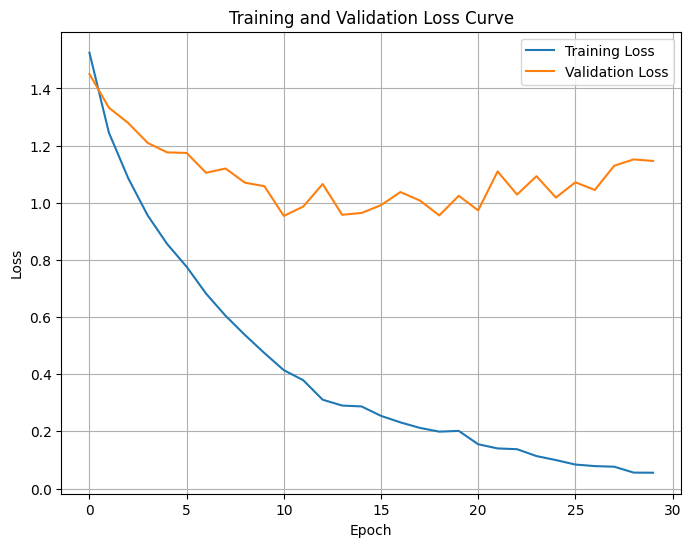

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


# 🔍 Confusion Matrix: Evaluating Model Predictions

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


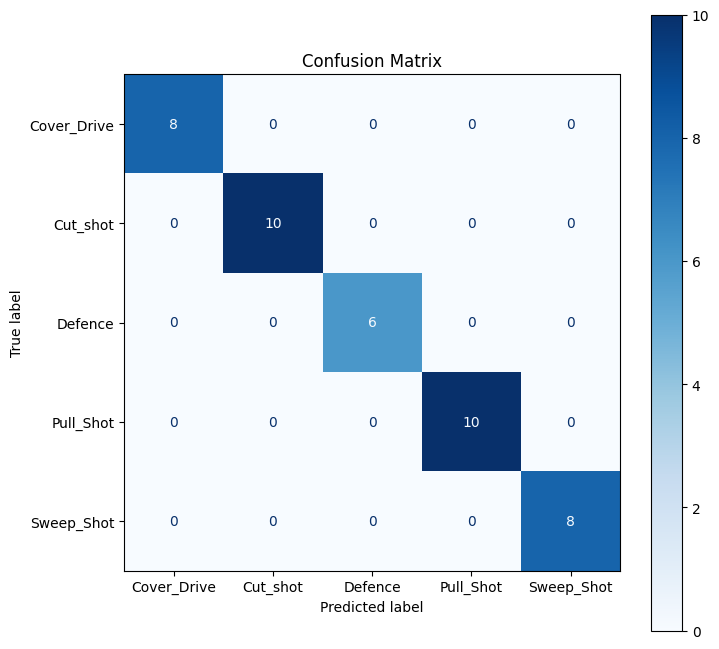

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Split your data into training and test sets (20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Assuming your model is already trained using X_train and y_train
# Get the true labels for the test set by converting one-hot encoded labels to integers
y_true = np.argmax(y_test, axis=1)

# Get model predictions on the test set and convert them to class indices
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix with proper labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


# 📝 Classification Report: Detailed Model Performance Evaluation

In [13]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Split your data into training and test sets (if not already done)
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Get the true labels from the test set by converting one-hot encoded labels to integers
y_true = np.argmax(y_test, axis=1)

# Get predictions from the model and convert predictions to class indices
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
print(report)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
              precision    recall  f1-score   support

 Cover_Drive       1.00      1.00      1.00         8
    Cut_shot       1.00      1.00      1.00        10
     Defence       1.00      1.00      1.00         6
   Pull_Shot       1.00      1.00      1.00        10
  Sweep_Shot       1.00      1.00      1.00         8

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42

